# Project 2

## Part 1 and 2
To simplify the problem, I will first break it into two parts: satellite selection and bike routing. 

## Satellite selection

#### Simplifications:
* As all satellites are relatively close to the other customers, distance between them and the other customers will not be considered in the satellite selection model. This is similar to saying that the satellite selection will be independent of the bike routes that result from it.
* As there are 5 vans available and a maximum of 3 satellites to be chosen, we'll assume that the van trips can be scheduled in such a way that a satellite can always be reloaded before its stock goes below that which a bike will need to refill (i.e. bikes can always fully refill when they come to a satellite). 
    * An underlying assumption for this is that the same number of vans will need to be sent regardless of the satellites selected, since the number of vans will be only dependent on total demand. So, the fixed cost of van transportation will be the same.
    * This makes some sense as the total demand is independent of number of satellites and there is a relatively high number of vans. However, I suspect this is my most impactful assumption that will need to be removed in a more perfect model.
* However, as a selection criteria, we will choose the satellites based on the requirement that one van per satellite (via back-and-forth trips) can supply the total average demand within 90 minutes. As the satellites have limited capacity, this naturally assumes that bikes are removing the stock at the satellites before the van comes back with more.
    * In this scenario, the vans can all be at a satellite by 8:00, and the bikes can start their first round then. Additional trips will arrive before 9:00, so bikes can continue their routes until 10:00.

Key constants:
* $a_s$ is the daily satellite cost
* $b_s$ is the cost of a single trip, considering dispatch cost and distance
* $q_{total}$ is the total average demand
* $F_{max}$ is the maximum number of satellites that may be chosen
* $c_s$ is the capacity at satellite $s$

To model this problem, we use variables:
* $x_s$: binary variable indicating whether satellite $s$ is chosen.
* $y_s$: integer variable indicating number of round trips to satellite $s$.

Sets:
* $F$: set of possible satellites, such that $s \in F$

The model will minimize cost of renting the satellite locations and of the transport during the 90-minute window.

$ min \sum\limits_{s \in F}a_s x_s + b_s y_s\qquad (1)$


Subject to the following constraints:

$\sum\limits_{s\in F}c_s y_s \geq q_{total}\qquad (2)$

$\sum\limits_{s\in F}x_s \leq SA_{max}\qquad (3)$

$y_s \leq x_s \lfloor\frac{g}{2\tau_s}\rceil\qquad (4)$

1. Objective function to minimize costs of satellite rental and van transport.
2. Ensures that all trips to the satellites can at least supply the average demand.
3. This ensures that no more than the maximum number of satellites are chosen.
4. Where $g$ is the target time frame within which we want to deliver all demand to the satellites (here, 90 min), $/tau_s$ is the van-time from depot to satellite $s$. As $g$ is an approximation anyway, we round the number of possible trips to nearest integer.


In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Approximate number of minutes all satellites should be able to receive 
# average total demand from the depot.
load_cycle = 90

distance_matrix = np.genfromtxt('distance_matrix.csv', delimiter=',')

time_matrix = np.genfromtxt('time_matrix.csv', delimiter=',')

# Map satellite indicies to distance_matric indicies
satellite_map = {0: 1,
                 1: 3,
                 2: 7,
                 3: 12}

# Distance from depot for satellite candidates
sat_distance = [distance_matrix[-1][i] for i in satellite_map.values()]

# Time from depot to satellite candidates
sat_time = [time_matrix[-1][i] for i in satellite_map.values()]

# Round trip cost per van trip
trip_cost = [2*.8*sat_distance[i]+100+25 for i in range(len(sat_distance))]

# Daily satellite cost
sat_cost = [60, 120, 130, 50]

# Satellite capacity
cap = [120, 150, 180, 100]

# (Approximate) number of possible trips per load_cycle per satellite
max_trips = [round(load_cycle/(sat_time[i]*2)) for i in range(len(sat_time))]

num_satellites = 4
satellites = range(num_satellites)

model = gp.Model("Satellites") # Make Gurobi model

# ---- Initialize variables

# Whether or not a node is chosen as a satellite
x = model.addVars(num_satellites, vtype=GRB.BINARY, name='x')

# Number of trips to each satellite
y = model.addVars(num_satellites, vtype=GRB.INTEGER, name='y')

# ---- Add constraints

# Ensure that all trips to satellites can supply the average demand
model.addConstr(gp.quicksum(y[i]*cap[i] for i in satellites) >= 390)

# Max satellites is 3
model.addConstr(gp.quicksum(x[i] for i in satellites) <= 3)

# Trips from depot to satellite can only occur if satellite is chosen,
# And number of trips to each depot cannot exceed maximum
model.addConstrs(y[i] <= x[i]*max_trips[i] for i in satellites)


# ---- Set objective

obj = gp.LinExpr()

obj.addTerms(sat_cost, [x[i] for i in satellites])
obj.addTerms(trip_cost, [y[i] for i in satellites])

model.setObjective(obj, GRB.MINIMIZE)

# ---- Optimize model
model.optimize()

# Extract variable values

x_values = []
y_values = []

for i in satellites:
    x_values.append(x[i].X)
    y_values.append(y[i].X)
    
print('\nSatellites: ', x_values)
print('Trips: ', y_values)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6 rows, 8 columns and 16 nonzeros
Model fingerprint: 0xf6c5414a
Variable types: 0 continuous, 8 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 4e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 5 rows, 7 columns, 14 nonzeros
Variable types: 0 continuous, 7 integer (4 binary)
Found heuristic solution: objective 595.3760000
Found heuristic solution: objective 587.9664000

Root relaxation: objective 4.663373e+02, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

This solutions suggests we use satellites 2 and 3.

Note that different time frames of 60 and 120 minutes were also tried. With a 60 minute window for deliveries, objective is €642, using satellites 0, 2, and 3 With a 120 minute window for deliveries, objective is €576, and only satellite 3 is used. With a 90 minute window, objective is €582, and satellites 2 and 3 are used. I chose to go with the 90 minute window, as this simulation is based on only averages with no variability, and 2 satellites offer more flexibility. Furthermore, this only costs €6 more.

## Bike tours
The following model is adapted from the paper:

Bard, Jonathan & Huang, Liu & Dror, Moshe & Jaillet, Patrick. (1998). 
A branch and cut algorithm for the VRP with satellite facilities. 
IIE Transactions. 30. 821-834. 10.1023/A:1007500200749. 

The key here is that dummy nodes are made for each satellite to allow a bike to pass through this location multiple times. The formulation is as follows:

Key constants:
* $n$: number of customers, excluding satellites
* $\bar{n}$: number of total nodes
* $m$: number of bikes available
* $Q$: bike capacity
* $\hat{Q}$: maximum inventory on bike before a refill is permitted
* $T$: maximum time per route
* $q_j$: demand at customer $j$
* $p_j$: load/ refill time at customer/satellite $j$
* $\tau_{i,j}$: time to get from customer $i$ to customer $j$


The following sets are used:
* $S$: nodes corresponding to a satellite
* $N_{\alpha}$: nodes where bikes can reload (copies of satellites)
* $N$: all nodes
* $I$: all customer nodes, where deliveries must occur
* $I_0$: customer nodes plus satellites (does not include copies)
* $I_F$: customer nodes plus copies of satellites (does not include actual satellites)

The following variables will be optimized:
* $x_{i,j}$: binary variable indicating whether a bike travels from node $i$ to node $j$
* $t_j$: continuous variable indicating time of arrival at node $j$
* $y_j$: continuous variable indicating the load on a bike before node $j$

As we only pay per bike, and not per time or distance travelled, the model will be run with increasing values of $m$ until a feasible solution is reached. Nevertheless, we want to minimize the time travelled on the bikes, so our objective function is:

$min \sum\limits_{i \in N, j \in N}\tau_{ij}x_{ij}$

Subject to the following constraints:

$\sum\limits_{j \in N}x_{ij} = 1 \quad \forall i \in I \qquad (5)$

$\sum_{j \in I}x_{ij} \leq 1 \quad \forall i \in N_{\alpha} \cup S \qquad (6)$

$\sum\limits_{i \in N}x_{ji} - \sum\limits_{i \in N}x_{ij} = 0 \quad \forall j \in N \qquad (7)$

$\sum\limits_{i \in S}\sum\limits_{j \in I}x_{ij} \leq m \qquad (8)$

$t_j \geq t_i + \tau_{ij}x_{ij} + p_j -T_{ij}(1-x_{ij}) \quad \forall i \in I_F \forall j \in N \qquad (9)$

$t_j \geq \max\limits_{i \in I}(2\min\limits_{s \in S}(\tau_{si})+p_i)\quad \forall j \in S \qquad (10)$

$t_j \geq \min\limits_{i \in S}\tau_{ij} \quad \forall j \in I \qquad (11)$

$t_j \leq T-(p_j+\min\limits_{i \in S}\tau_{ij}) \quad \forall j \in \qquad (12)$

$t_j \geq \min\limits_{i \in I, s \in S}(\tau_{si}+p_i + \tau_{ij}) \quad \forall j \in N_{\alpha}\qquad (13)$

$t_j \leq \max\limits_{i \in I, s \in S}(T-p_j-\tau_{ji}-p_i-\tau_{is}) \quad \forall j \in N_{\alpha}\qquad (14)$

$y_j \leq y_i - \bar{q}_{i}x_{ij} + \bar{Q}_i(1-x_{ij}) \quad \forall i \in I_F, \forall j \in N \qquad (15)$

$y_j \geq q_j \quad \forall j \in I \qquad (16)$

$y_j \leq \hat{Q} \quad \forall j \in N_{\alpha} \qquad (17)$

where

$
T_{ij}= 
    \begin{cases}
        T-\min\limits_{s \in S}(\tau_{sj}) - (p_i + \min\limits_{s \in S}(\tau_{is})) & \quad if \quad i \in I \\
        T-\min\limits_{s \in S}(\tau_{sj}) - \min\limits_{k \in I}(p_i + \tau_{ik} + p_k + \min\limits_{s \in S}(\tau_{ks})) & \quad if \quad i \in I_F\\
    \end{cases}
$

$
\bar{q}_i=
    \begin{cases}
        q_i & \quad if \quad i \in I \\
        -Q & \quad if \quad i \in I_F \\
    \end{cases}
$

$
\bar{Q}_i=
    \begin{cases}
        Q - q_i & \quad if \quad i \in I \\
        Q & \quad if \quad i \in I_F \\
    \end{cases}    
$





These constraints do the following:

5. Ensures each customer has exactly 1 successor.
6. Ensures each (copy of a) satellite has at most one successor.
7. Ensures number of arrivals at a node equals the number of departures.
8. No more than $m$ vehicles used (specifically, only m vehicles can start from a depot).
9. Tracks the time a service begins at node $j$. Also functions to eliminate subtours. 
10. Lower bound for arrival back at depot. Must be at least as long as visiting the farthest customer, dropping off the load, and returning to depot.
11. Lower bound for $t$ at customer nodes. There must be enough time to get to the customer from the depot.
12. Upper bound for $t$ at customer nodes. There must be enough time left for the bike to get back to the depot
13. Minimum amount of time to go from depot to customer, provide service, and go to a satellite.
14. Latest time to depart satellite/depot $j$, visit a customer, and return to the depot arriving no later than $T$.
15. Tracks the load on a bike just prior to visiting node $j$
16. Load must be high enough to service the customer
17. Load must be under $\hat{Q}$ if bike will stop at a depot/satellite


## 3. Solve the model

In [2]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

from plots import nmap

# ---- Global variables ----
n = 14  # Number of customers
n_bar = 22  # Total nodes
m = 2  # Number of bikes available
Q = 80  # Bike capacity
Q_hat = 40  # Max inventory on bike before refill permitted
T = 120  # Max time per route

# Satellite indicies, determined from satellite_selection.py
Satellites = (7, 12)


def create_ave_demand_arr(Satellites):
    """Creates 1D numpy array with average demand per customer"""
    
    demand = np.genfromtxt('demand.csv', delimiter=',')[1:17,1:]
    
    # Average demand per customer. Round up as we deal with whole units
    d_with_sats = np.mean(demand, axis=1)
    d_with_sats = np.ceil(d_with_sats)
    
    # Set satellite demands to 0
    demands_ave = []
    for i in range(len(d_with_sats)):
        if i not in Satellites:
            demands_ave.append(d_with_sats[i])
        else:
            demands_ave.append(0)
    return demands_ave

def create_model(Q):
    # Arrays below must be referenced using nmap
    q = create_ave_demand_arr(Satellites)  # Demand at nmap[j]
    p = [10 if i in Satellites else 5 for i in range(len(q))] # Load/refill time

    q_bar = [-Q if i in Satellites else q[i] for i in range(len(q))]
    Q_bar = [Q if i in Satellites else Q - q[i]for i in range(len(q))]


    # Time from i to j by bike
    tau = np.genfromtxt('time_matrix_bike.csv', delimiter=',')  

    T_array = []

    for i in range(len(tau)-1): # Subtract 1 since last row of tau is (real) depot
        T_list = []
        for j in range(len(tau)-1):
            if i in Satellites:
                temp_list = [p[i] + tau[i,k] + p[k] \
                             + min(tau[k, Satellites[0]], tau[k, Satellites[1]]) 
                             for k in range(len(p))]
                T_list.append(T-min(tau[Satellites[0],j], tau[Satellites[1],j]) \
                              - min(temp_list))
            else:
                T_list.append(T - min(tau[Satellites[0],j], tau[Satellites[1],j]) \
                              - (p[i] + min(tau[i, Satellites[0]], 
                                            tau[i, Satellites[1]])))

        T_array.append(T_list)

    # Lower bound for t[0]
    t_lb = max([2*min(tau[Satellites[0],i], tau[Satellites[1],i]) + p[i] 
                for i in range(len(p)) if i not in Satellites])  

    tj_min = [min([min(tau[Satellites[0],i], tau[Satellites[1],i]) + p[i] + tau[i,j] 
                   for i in range(len(p))]) for j in range(len(p))]

    tj_max = [max([T - p[j] - tau[j,i] - p[i] \
                   - min(tau[i, Satellites[0]], tau[i, Satellites[1]]) 
                   for i in range(len(p))]) for j in range(1,len(p))]

    # Below here we use node indexes, no nmap is needed when referring to
    # x, t, y

    # ---- Sets ---- 

    S = (0,15)  # Nodes corresponding to a satellite
    N_a = range(16,22)  # Nodes where bikes can reload (copies of satellites)
    N = range(22)  # All nodes
    I = range(1,15)  # All customer nodes, where a delivery must occur
    I0 = range(16)  # Customer nodes plus satellites
    I_F = [i for i in range(1,22) if i !=15]  # Nodes not including satellites

    model = gp.Model("Design") # Make Gurobi model


    # ---- Initialize variables

    # Travel from node i to j for bike b           
    x = model.addVars(n_bar, n_bar, vtype=GRB.BINARY, name='x') 

    t = model.addVars(n_bar, vtype=GRB.CONTINUOUS, lb=0, ub=T, name='t')

    y = model.addVars(n_bar, vtype=GRB.CONTINUOUS, lb=0, ub=Q, name = 'y')


    # ---- Add constraints

    # Ensure each customer has exactly 1 successor
    model.addConstrs(gp.quicksum(x[i,j] for j in N if i !=j) == 1 for i in I)

    # Each copy of a satellite has at most one successor
    model.addConstrs(gp.quicksum(x[i,j] for j in I if i !=j) <= 1 for i in N_a)

    # Each satellite has at most one successor
    model.addConstrs(gp.quicksum(x[i,j] for j in I if i !=j) <= 1 for i in S)

    # Number of arrivals at a node equal number of departures
    model.addConstrs(gp.quicksum(x[j,i] for i in N if i != j) 
                     - gp.quicksum(x[i,j] for i in N if i != j)
                     == 0 for j in N)

    # No more than m vehicles used (i.e. only m vehicles can start journey at a depot)
    model.addConstr(gp.quicksum(x[i,j] for i in S for j in I) <= m)
    # model.addConstr(gp.quicksum(x[j,0]+x[j,15] for j in I) <= m)

    # Tracks the time a service begins at node j. Also functions to eliminate subtours
    model.addConstrs(t[j] >= t[i] + tau[nmap[i],nmap[j]]*x[i,j] + p[nmap[j]] 
                     - T_array[nmap[i]][nmap[j]] * (1-x[i,j]) 
                     for i in I_F for j in N if i != j)

    # Lower bound for arrival back at depot. Must be at least as long as visiting
    # the farthest customer, dropping off the load, and returning to depot
    model.addConstrs(t[s] >= t_lb for s in S)

    # Lower bound for t at customer nodes. There must be enough time to get to the
    # customer from the depot.
    model.addConstrs(t[j] >= min(tau[Satellites[0], nmap[j]], 
                                 tau[Satellites[1], nmap[j]]) 
                     for j in I)

    # Upper bound for t at customer nodes. There must be enough time left for the
    # bike to get back to the depot
    model.addConstrs(t[j] <= T - (p[nmap[j]] \
                                  + min(tau[nmap[j], Satellites[0]], 
                                        tau[nmap[j], Satellites[1]])) 
                     for j in I)

    # Minimum amount of time to go from depot to customer, provide service, and go
    # to a satellite.
    model.addConstrs(t[j] >= tj_min[nmap[j]] for j in N_a)

    # Latest time to depart satellite/depot j, visit a customer, and return to
    # The depot arriving no later than T
    model.addConstrs(t[j] <= tj_max[nmap[j]] for j in N_a)

    # Tracks the load on a bike just prior to visiting node j
    model.addConstrs(y[j] <= y[i] - q_bar[nmap[i]]*x[i,j] \
                     + Q_bar[nmap[i]]*(1-x[i,j])
                     for i in I_F for j in N if i != j)

    # Load must be high enough to service the customer
    model.addConstrs(y[j] >= q[nmap[j]] for j in I)

    # Load must be under Q_hat if bike will stop at a depot/satellite
    model.addConstrs(y[j] <= Q_hat for j in N_a)


    # ---- Set objective

    obj = gp.LinExpr()


    for i in N:
        for j in N:
            if i != j:
                obj.addTerms(tau[nmap[i], nmap[j]], x[i, j])


    model.setObjective(obj, GRB.MINIMIZE)
    
    return model, x, y, t

model, x, y, t = create_model(Q=80)

model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 947 rows, 528 columns and 3814 nonzeros
Model fingerprint: 0x3dfecf32
Variable types: 44 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
Presolve removed 321 rows and 38 columns
Presolve time: 0.04s
Presolved: 626 rows, 490 columns, 5472 nonzeros
Variable types: 34 continuous, 456 integer (450 binary)

Root relaxation: objective 8.637208e+01, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   86.37208    0   28          -   86.37208      -     -

A feasable solution was found, with a travel time of about 139 minutes, which means at least 2 bikes are needed. But, more interesting is what routes the bikes will actually take. 

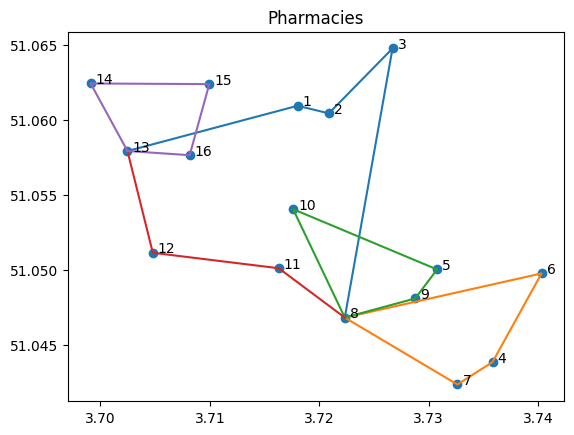

In [3]:
import plots as pl

def generate_plot():
    N = range(len(y))
    x_values = np.zeros((len(N), len(N)))
    y_values = np.zeros(len(N))
    t_values = np.zeros(len(N))

    # Fill in the values from the flattened array
    for i in N:
        y_values[i] = y[i].X
        t_values[i] = t[i].X
        for j in N:
            if i != j:
                x_values[i, j] = x[i, j].X

    S = (0,15)
    pl.plot_routes(x_values, S)
    
    return x_values
    
x_values = generate_plot()

## 3. Accounting for variability

In the variability assessment, we maintain the assumption that the 5 vans are adequately able to supply the 2 satellites such that the bikes can refill whenever they enter. However, when the bikes follow the routes above, they may not have enough supply to meet the demand of all of the customers. 

The script below assumes the bikes follow the same routes and pick up the maximum load. The number of times their load is no longer able to service all of the customes on the route is tallied and divided by the number of customers that could have been serviced if the load was sufficient.

Demand for each customer is selected from a normal distribution with mean and standard deviation calculated from the historical data.

In [4]:
#from network_model import create_ave_demand_arr, Satellites
from plots import make_node_routes

satellite_nodes = (0, 15)

def create_std_demand_arr(Satellites):
    """Creates 1D numpy array with stdev demand per customer"""
    
    demand = np.genfromtxt('demand.csv', delimiter=',')[1:17,1:]
    
    # Stdev of demand per customer. Round up as we deal with whole units
    d_with_sats = np.std(demand, axis=1)
    # d_with_sats = np.ceil(d_with_sats)
    
    # Set satellite demands to 0
    demands_stdev = []
    for i in range(len(d_with_sats)):
        if i not in Satellites:
            demands_stdev.append(d_with_sats[i])
        else:
            demands_stdev.append(0)
            
    return demands_stdev

def create_rand_demand_arr(Satellites, seed):
    np.random.seed(seed)
    demands_ave = create_ave_demand_arr(Satellites)
    demands_stdev = create_std_demand_arr(Satellites)
    demands_stdev = [np.random.normal(ave, std) for ave, std in zip(demands_ave, demands_stdev)]
    return np.ceil(demands_stdev)

def calc_service_level():
    num_scenarios = 100
    
    unfulfilled_demand_tally = 0
    for seed in range(num_scenarios):
        demands_rand = create_rand_demand_arr(Satellites, seed)
    
        customer_routes = make_node_routes(x_values, satellite_nodes)
    
        # stocks = []
        for route in customer_routes:
            route_no_sat = [cust for cust in route if cust not in Satellites]
            # stock = [80]
            stock = 80 #
            for customer in route_no_sat:
                # remaining_stock = stock[-1]-demand_rand[customer]
                stock -= demands_rand[customer]
                # if remaining_stock < 0:
                if stock < 0: #
                    unfulfilled_demand_tally += 1
                # stock.append(remaining_stock)
            # stocks.append(stock)
        
    return 1-unfulfilled_demand_tally/(len(demands_rand)*num_scenarios)

service_level = calc_service_level()

print('Service level: ', service_level)

Service level:  0.925625


## 5. Increase service level

To increase the service level with the current design, we keep the same satellites and assumption that vans are capable of refiling them. Therefore, we must change the bike route. If formulate the bike routes on the assumption that the bikes can only carry 60 (instead of 80) units, then the bikes will be more likely to carry enough units to satisfy all the customers on their routes. The new model and routes are shown below.

In [5]:
model, x, y, t = create_model(Q=60)

model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 947 rows, 528 columns and 3814 nonzeros
Model fingerprint: 0xf5339abf
Variable types: 44 continuous, 484 integer (484 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
Presolve removed 338 rows and 50 columns
Presolve time: 0.04s
Presolved: 609 rows, 478 columns, 5243 nonzeros
Variable types: 34 continuous, 444 integer (438 binary)

Root relaxation: objective 8.699056e+01, 79 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   86.99056    0   28          -   86.99056      -     -

Thread count was 16 (of 16 available processors)

Solution count 10: 168.2 168.967 169.2 ... 255.567

Optimal solution found (tolerance 1.00e-04)
Best objective 1.682000000000e+02, best bound 1.682000000000e+02, gap 0.0000%


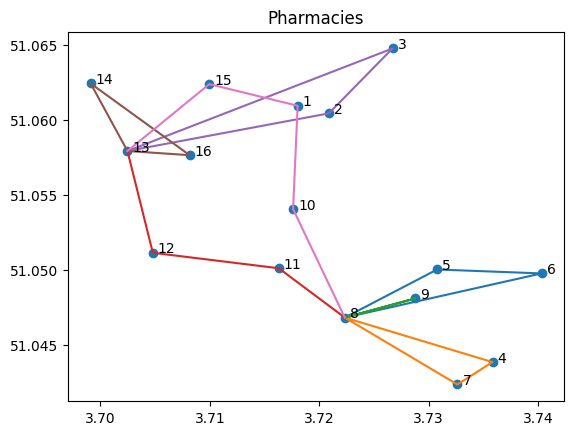

In [6]:
x_values = generate_plot()

In [7]:
service_level = calc_service_level()
print('Service level: ', service_level)

Service level:  0.995625


Here, we see we have a service level > 99%. This can also be done with only 2 bikes (in the model, the maximum bikes is still m=2).


## 6. Include the service level as a parameter in the optimization model.

Perhaps something realted to the family capacitated vehicle routing problem (F-CVRP), where customers are broken into groups called 'families', and the goal is to visit a certain number of customers in each family.

https://www.sciencedirect.com/science/article/pii/S0377221723008172